In [6]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = Aer.get_backend('pulse_simulator')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

ibmqfactory.load_account:WARNING:2020-06-10 06:05:02,281: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")
rough_qubit_frequency = center_frequency_Hz 
# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

AttributeError: 'BackendConfiguration' object has no attribute 'dt'

In [3]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of inf GHz.


ValueError: arange: cannot compute length

In [8]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [9]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

NameError: name 'dt' is not defined

In [20]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [21]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [22]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [10]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

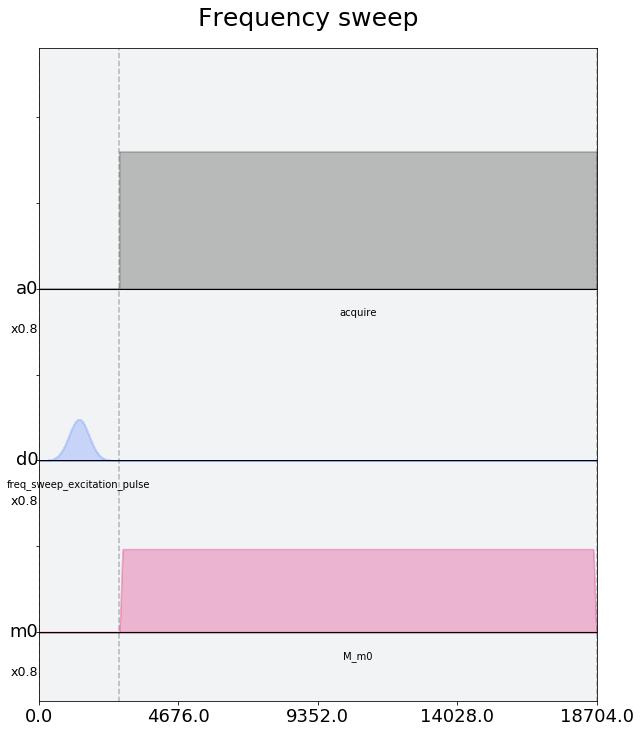

In [11]:
schedule.draw(label=True, scaling=0.8)

In [12]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [13]:
job = backend.run(frequency_sweep_program)

In [14]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [15]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

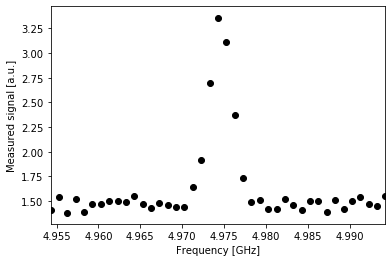

In [16]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [17]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [35]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [7, 4.975, 1, 3] # initial parameters for curve_fit
                                )

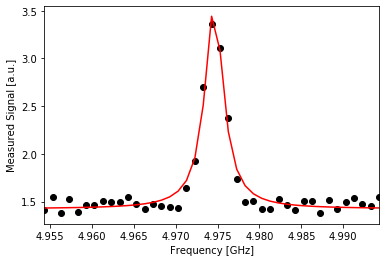

In [36]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [37]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97428 GHz to 4.97458 GHz.


In [38]:
rough_qubit_frequency

4974581777.40711

In [39]:
pi_amp = 0.2773296097765178

In [40]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [41]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [42]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

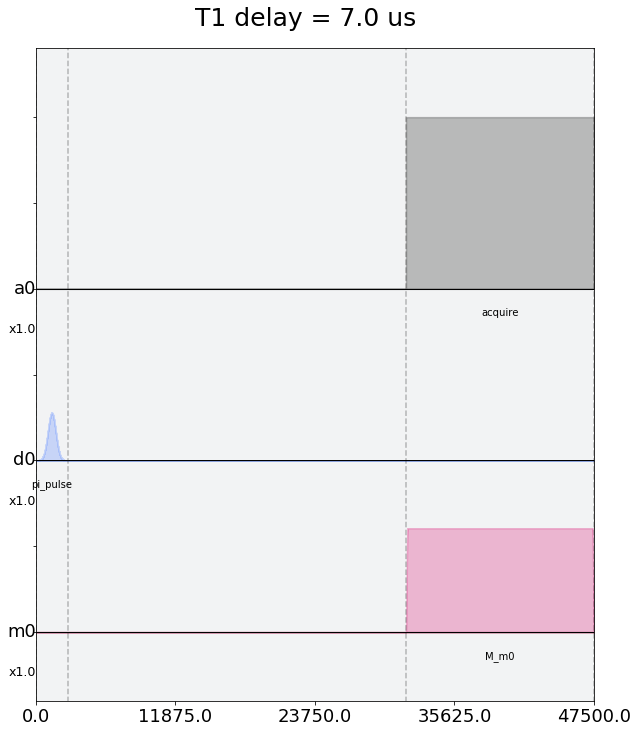

In [43]:
sched_idx = 0
t1_schedules[1].draw(label=True, scaling=1.0)

In [44]:
# Execution settings
num_shots = 256

t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))

In [45]:
job = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


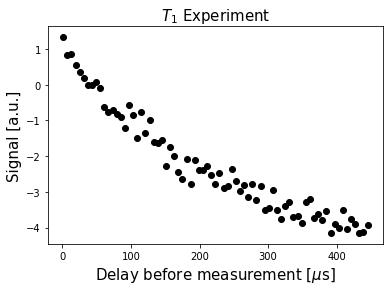

In [46]:
t1_results = job.result(timeout=120)
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

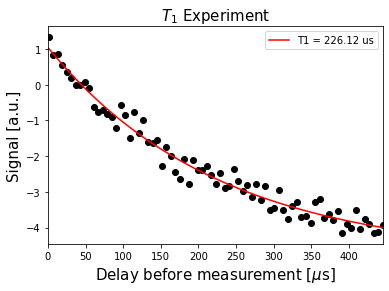

In [49]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [23]:
from scipy.optimize import curve_fit
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib 
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

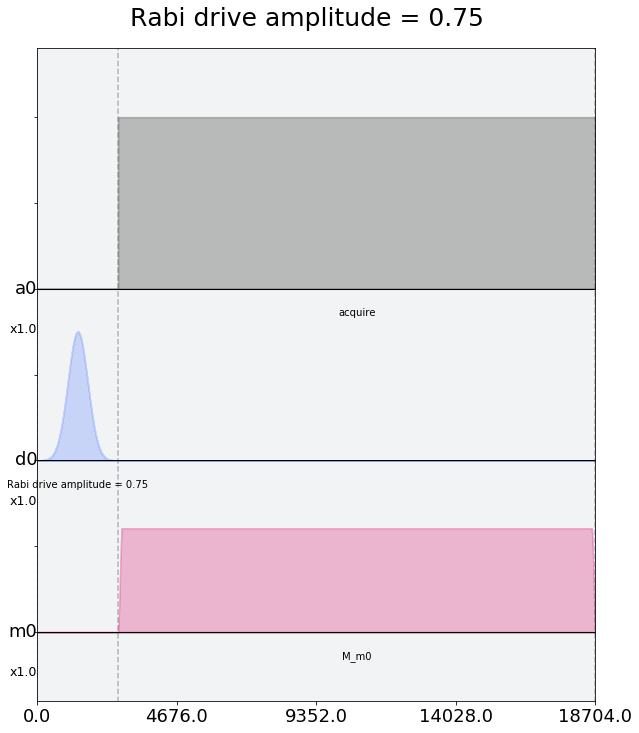

In [24]:
rabi_schedules[-1].draw(label=True, scaling=1.0)

In [27]:
from qiskit import assemble
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [29]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor

# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


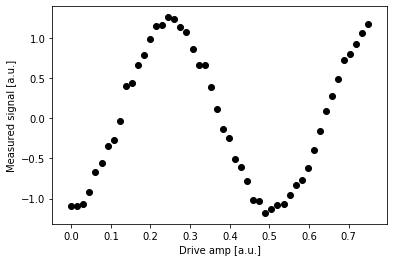

In [31]:
import matplotlib.pyplot as plt

rabi_results = job.result(timeout=120)
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

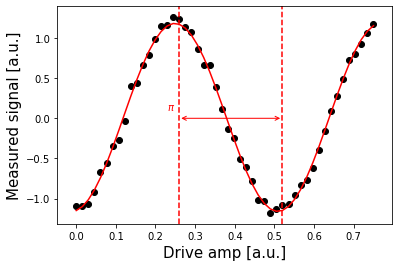

In [33]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [34]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.2598503623551238


In [35]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')
scaled_pi_pulse = pulse_lib.gaussian(duration=2*drive_samples,
                              amp=(pi_amp/2), 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [36]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [37]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)
    
# Create schedules for the experiment 
t1_scaled_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(scaled_pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_scaled_schedules.append(this_schedule)
    

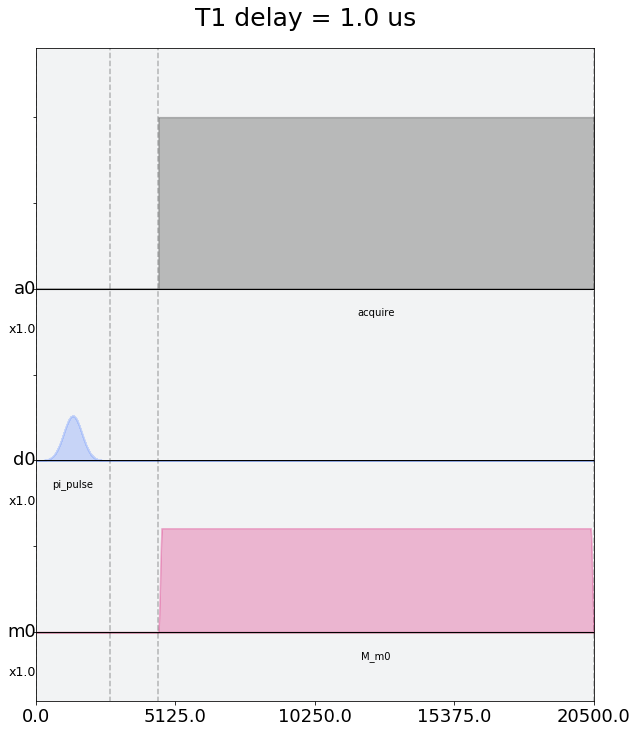

In [38]:
sched_idx = 0
t1_schedules[sched_idx].draw(label=True, scaling=1.0)

In [42]:
# Execution settings
num_shots = 256

extrap_program_nonscaled = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))

extrap_program = assemble(t1_scaled_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))

In [43]:
job = backend.run(extrap_program)
joby = backend.run(extrap_program_nonscaled)
# print(job.job_id())
job_monitor(job)
job_monitor(joby)

Job Status: job has successfully run
Job Status: job has successfully run


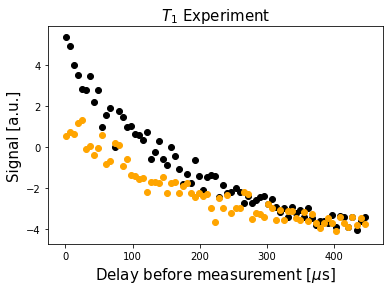

In [44]:
t1_scaled_results = job.result(timeout=120)
t1_results = joby.result(timeout=120)


t1_values = []
t1_scaled_values =[]
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)
    t1_scaled_values.append(t1_scaled_results.get_memory(i)[qubit]*scale_factor)

t1_values = np.real(t1_values)
t1_scaled_values = np.real(t1_scaled_values)

plt.scatter(times_us, t1_values, color='black') 
plt.scatter(times_us, t1_scaled_values, color='orange') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

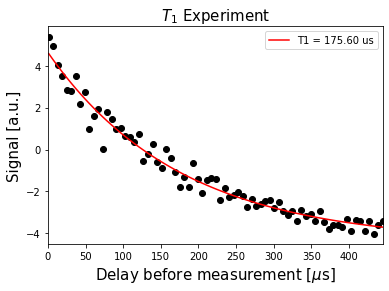

In [45]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()